# Day 7: Week 8 Review - Instance-Based Methods Interview Prep

## 🎯 Learning Objectives
- Consolidate instance-based learning methods
- Build comprehensive comparison pipeline
- Practice interview questions

---

## 📚 Week Summary

| Day | Topic | Key Concept |
|-----|-------|-------------|
| 1 | kNN | Nearest neighbor classification |
| 2 | SVR | Support vector regression |
| 3 | Kernel Methods | Kernel trick, RBF |
| 4 | LOWESS | Local regression |
| 5 | Distance Metrics | Euclidean, Mahalanobis, Cosine |
| 6 | LSH | Approximate nearest neighbors |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from statsmodels.nonparametric.smoothers_lowess import lowess
import time

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 1255 days


In [2]:
# Comprehensive features
df = pd.DataFrame(index=prices.index)
df['price'] = prices
df['return'] = returns

for lag in [1, 5, 10, 20]:
    df[f'momentum_{lag}'] = prices.pct_change(lag)

for window in [5, 10, 20]:
    df[f'volatility_{window}'] = returns.rolling(window).std()

df['ma_ratio'] = prices / prices.rolling(20).mean() - 1

delta = prices.diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
df['rsi'] = 100 - (100 / (1 + gain / loss))

df['next_return'] = returns.shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

df = df.dropna()
feature_cols = [c for c in df.columns if c not in ['price', 'return', 'next_return', 'target']]

print(f"📊 Features: {len(feature_cols)}, Samples: {len(df)}")

📊 Features: 9, Samples: 1234


In [3]:
# Prepare data
X = df[feature_cols]
y = df['target']

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
returns_test = df['next_return'].iloc[split_idx:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 987, Test: 247


In [4]:
# Compare all instance-based methods
models = {
    'kNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'kNN (k=10)': KNeighborsClassifier(n_neighbors=10),
    'kNN (k=20)': KNeighborsClassifier(n_neighbors=20),
    'SVM (RBF)': SVC(kernel='rbf', probability=True),
    'SVM (Linear)': SVC(kernel='linear', probability=True),
    'SVM (Poly)': SVC(kernel='poly', degree=3, probability=True)
}

print("\n" + "="*70)
print("INSTANCE-BASED METHODS COMPARISON")
print("="*70)

results = []
predictions = {}
probabilities = {}

for name, model in models.items():
    start = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start
    
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    predictions[name] = y_pred
    probabilities[name] = y_proba
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': f'{acc:.2%}',
        'F1': f'{f1:.2%}',
        'Time': f'{train_time:.3f}s'
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


INSTANCE-BASED METHODS COMPARISON
       Model Accuracy     F1   Time
   kNN (k=5)   55.47% 57.36% 0.003s
  kNN (k=10)   54.25% 47.93% 0.001s
  kNN (k=20)   47.77% 44.16% 0.001s
   SVM (RBF)   54.25% 66.07% 0.104s
SVM (Linear)   52.23% 68.62% 0.092s
  SVM (Poly)   51.42% 65.52% 0.082s


In [5]:
# Trading backtest
backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = returns_test.values

for name in predictions.keys():
    safe_name = name.replace(' ', '_').replace('(', '').replace(')', '').replace('=', '')
    backtest[f'{safe_name}_signal'] = predictions[name]
    backtest[f'{safe_name}_return'] = predictions[name] * backtest['actual_return']
    backtest[f'{safe_name}_cum'] = (1 + backtest[f'{safe_name}_return']).cumprod()

backtest['buy_hold_cum'] = (1 + backtest['actual_return']).cumprod()

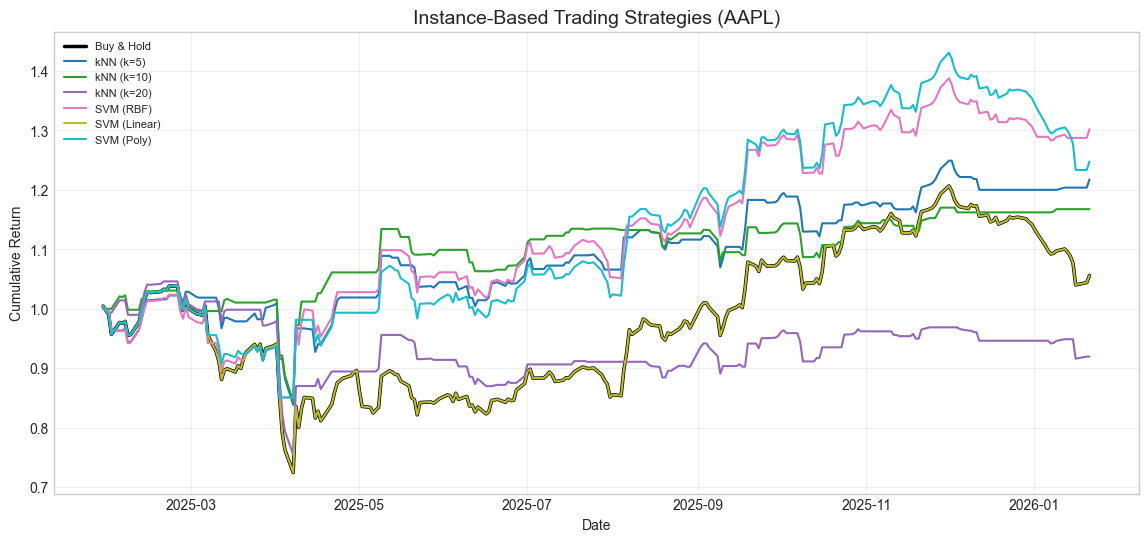

In [6]:
# Plot top models
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2.5, color='black')

colors = plt.cm.tab10(np.linspace(0, 1, len(predictions)))
for (name, _), color in zip(predictions.items(), colors):
    safe_name = name.replace(' ', '_').replace('(', '').replace(')', '').replace('=', '')
    plt.plot(backtest.index, backtest[f'{safe_name}_cum'], label=name, linewidth=1.5, color=color)

plt.title(f'Instance-Based Trading Strategies ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Performance summary
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*70)
print("STRATEGY PERFORMANCE")
print("="*70)

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 55)

# Buy and hold
total, sharpe, mdd = calc_metrics(backtest['actual_return'], backtest['buy_hold_cum'])
print(f"{'Buy & Hold':<20} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")

# All models
for name in predictions.keys():
    safe_name = name.replace(' ', '_').replace('(', '').replace(')', '').replace('=', '')
    total, sharpe, mdd = calc_metrics(backtest[f'{safe_name}_return'], backtest[f'{safe_name}_cum'])
    print(f"{name:<20} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")


STRATEGY PERFORMANCE

Strategy                Total Ret     Sharpe     Max DD
-------------------------------------------------------
Buy & Hold                  5.61%       0.17    -30.22%
kNN (k=5)                  21.76%       0.71    -18.49%
kNN (k=10)                 16.76%       0.57    -18.17%
kNN (k=20)                 -8.04%      -0.39    -27.88%
SVM (RBF)                  30.22%       0.90    -16.92%
SVM (Linear)                5.61%       0.17    -30.22%
SVM (Poly)                 24.77%       0.75    -18.04%


In [8]:
# Next day predictions - all models
latest_scaled = scaler.transform(X.iloc[[-1]])

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTIONS FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")

print(f"\n{'Model':<20} {'Prediction':>15} {'Confidence':>12}")
print("-" * 50)

bullish = 0
for name, model in models.items():
    pred = model.predict(latest_scaled)[0]
    proba = model.predict_proba(latest_scaled)[0, 1]
    direction = '📈 UP' if pred == 1 else '📉 DOWN'
    bullish += pred
    print(f"{name:<20} {direction:>15} {proba:>12.1%}")

print(f"\n🎯 Consensus: {bullish}/{len(models)} models bullish")


📊 NEXT DAY PREDICTIONS FOR AAPL

Date: 2026-01-21

Model                     Prediction   Confidence
--------------------------------------------------
kNN (k=5)                       📈 UP        60.0%
kNN (k=10)                    📉 DOWN        50.0%
kNN (k=20)                    📉 DOWN        50.0%
SVM (RBF)                       📈 UP        51.7%
SVM (Linear)                    📈 UP        50.7%
SVM (Poly)                      📈 UP        52.6%

🎯 Consensus: 4/6 models bullish


---

## 📝 Interview Questions & Answers

### Q1: When to use kNN vs SVM?
**A:** 
- kNN: Simple, interpretable, no training time
- SVM: Better with clear margins, handles high dimensions

### Q2: Why scale features for kNN?
**A:** Distance metrics are sensitive to scale. Without scaling, features with larger values dominate.

### Q3: Kernel trick explanation?
**A:** Maps data to higher dimensions implicitly via kernel function, making linear separation possible.

### Q4: kNN complexity?
**A:** Training O(1), Prediction O(n·d) where n=samples, d=dimensions. Can use KD-trees or LSH to improve.

### Q5: Choice of k in kNN?
**A:** Cross-validation. Too small = overfitting, too large = underfitting. Odd k avoids ties.

---

## 🏢 Company Use Cases

| Company | Instance-Based Application |
|---------|---------------------------|
| Two Sigma | Pattern matching |
| DE Shaw | Regime classification |
| Citadel | Similar market conditions |
| AQR | Factor similarity |

---

## 📅 Next Week: Unsupervised Learning (Clustering, PCA)